### Calculation of Relative Humidity from ERA5 dataset

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
from datetime import datetime
import warnings

warnings.simplefilter("ignore")

## Relative humidity - hourly - 2020/03 -2021/02

In [2]:
path_init  = '/g/data/rt52/era5/pressure-levels/reanalysis/r/2020/r_era5_oper_pl_20200401-20200430.nc'
path_final = '/g/data/rt52/era5/pressure-levels/reanalysis/r/2021/r_era5_oper_pl_20210301-20210331.nc'

In [3]:
import xarray as xr
import glob
from datetime import datetime

all_files = sorted(glob.glob("/g/data/rt52/era5/pressure-levels/reanalysis/r/202[0-1]/r_era5_oper_pl_202*.nc"))

# Filter only files between March 2020 and Feb 2021
files = [
    f for f in all_files
    if datetime.strptime(f.split("_")[-1].split(".")[0][:8], "%Y%m%d") >= datetime(2020, 4, 1)
    and datetime.strptime(f.split("_")[-1].split(".")[0][:8], "%Y%m%d") <= datetime(2021, 3, 31)
]

#loadingggg
ds = xr.open_mfdataset(
    files,
    combine='by_coords',
    parallel=True
    # chunks={'time': 24, 'lat': 180, 'lon': 360}  # Optional chunking for Dask
)


In [4]:
ds

<xarray.Dataset> Size: 2TB
Dimensions:    (time: 8016, level: 37, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) int32 148B 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 64kB 2020-04-01 ... 2021-03-31T23:00:00
Data variables:
    r          (time, level, latitude, longitude) float64 2TB dask.array<chunksize=(1, 1, 81, 180), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-11-15 20:51:20 UTC+1100 by era5_replication_tools-1.7....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 pressure-levels oper relative_humidity 20200401-20200430

In [5]:
r_subset = ds['r'].sel(
    latitude=slice(13, -13),    # Note: decreasing because ERA5 latitudes go from 90 to -90
    longitude=slice(100, 149)
)


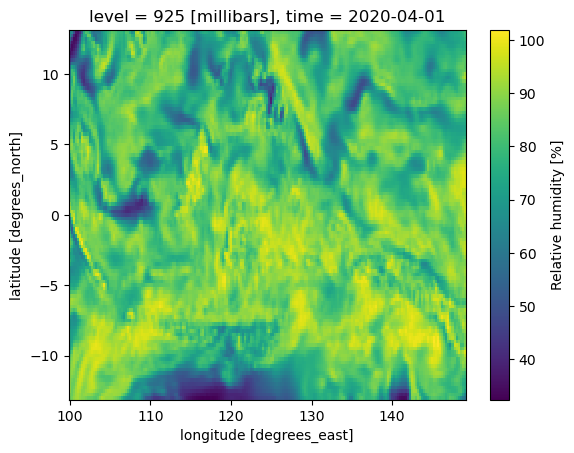

In [6]:
r_subset[0,33,:,:].plot()

In [7]:
print(r_subset)

<xarray.DataArray 'r' (time: 8016, level: 37, latitude: 105, longitude: 197)> Size: 49GB
dask.array<getitem, shape=(8016, 37, 105, 197), dtype=float64, chunksize=(1, 1, 81, 140), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 788B 100.0 100.2 100.5 ... 148.5 148.8 149.0
  * latitude   (latitude) float32 420B 13.0 12.75 12.5 ... -12.5 -12.75 -13.0
  * level      (level) int32 148B 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 64kB 2020-04-01 ... 2021-03-31T23:00:00
Attributes:
    units:          %
    long_name:      Relative humidity
    standard_name:  relative_humidity


In [8]:
r_600_1000 = r_subset.sel(level=slice(600, 800))

In [9]:
%%time

r_700 = r_600_1000.sel(level=700).compute()

CPU times: user 2min 29s, sys: 13.8 s, total: 2min 42s
Wall time: 3min 12s


In [10]:
print(r_700)

<xarray.DataArray 'r' (time: 8016, latitude: 105, longitude: 197)> Size: 1GB
array([[[60.44728202, 65.78927774, 70.48582286, ..., 11.66873087,
         14.99004455, 17.49724716],
        [60.15212621, 65.94820779, 69.72685079, ..., 14.80841021,
         18.90491331, 22.12892287],
        [54.79391313, 62.70149393, 65.62386075, ..., 16.71881427,
         20.28987516, 23.60145843],
        ...,
        [76.19757421, 79.01939345, 79.70700917, ..., 68.64677515,
         62.48418142, 55.94210165],
        [76.87870299, 79.73944387, 79.7362004 , ..., 59.45802355,
         52.70836167, 47.11013179],
        [77.34251926, 79.55132259, 79.63565282, ..., 50.1427766 ,
         46.99985379, 44.15857373]],

       [[62.62040717, 66.72988415, 69.68144221, ..., 10.02753486,
         11.16599296, 12.60933729],
        [62.75014599, 66.308233  , 67.79374244, ..., 13.16397072,
         15.07761825, 16.7480055 ],
        [58.07630516, 63.21720573, 63.32748372, ..., 15.13275725,
         17.67239456, 19.9

In [11]:
## Calculating domain average rh (700 hpa)

r700_spatial_mean = r_700.mean(dim=['latitude', 'longitude'])
r700_spatial_mean

<xarray.DataArray 'r' (time: 8016)> Size: 64kB
array([61.23892588, 60.78147221, 60.38572507, ..., 69.79066718,
       70.38293325, 70.19465778])
Coordinates:
    level    int32 4B 700
  * time     (time) datetime64[ns] 64kB 2020-04-01 ... 2021-03-31T23:00:00

In [12]:
r700_spatial_mean.to_netcdf(
    "/scratch/nf33/gs5098/data/r_700_mean_100_149_-13_13_2020_04_2021_03.nc",
    encoding={"r": {"dtype": "float32"}},
    format="NETCDF4"
)